In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import collections, numpy
import seaborn as sns 
import scipy.stats
from functionsACP import *
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn import preprocessing
from matplotlib.collections import LineCollection
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans
from sklearn import decomposition
from scipy.stats import ks_2samp
import statsmodels
from pandas.api.types import CategoricalDtype
from plotnine import *
import geopandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Importation des données 

In [115]:
#importation des données  FAO
temp = pd.read_csv("p5_donnees_FAO.csv")
listepays = pd.read_csv("listePop.csv")

# Nettoyage et mise en forme des données 

In [116]:
#retrait des agrégats de pays 
listepays = listepays[listepays["Symbole"]!= "A"]
listepays = listepays[["Zone"]]
temp["is_in_listpays"]= temp.Zone.isin(listepays["Zone"])
temp = temp[temp["is_in_listpays"]== True]
temp.describe(include = "all")

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,is_in_listpays
count,6017,6017,6017,6017,6017.000000,6017,6017.000000,6017,6017.000000,6017.000000,6017,6.017000e+03,6017,6017,6017
unique,1,1,172,172,NaN,17,NaN,4,NaN,NaN,5,NaN,2,2,1
top,FBS,Nouveaux Bilans Alimentaire,TCD,Tchad,NaN,Disponibilité de protéines en quantité (g/pers...,NaN,Viande de Volailles,NaN,NaN,Milliers de tonnes,NaN,S,Données standardisées,True
freq,6017,6017,44,44,NaN,1032,NaN,3961,NaN,NaN,3269,NaN,3609,3609,6017
mean,NaN,NaN,NaN,NaN,3193.893302,NaN,2750.432109,NaN,2015.454379,2015.454379,NaN,2.729374e+03,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,2343.155769,NaN,118.135721,NaN,1.499431,1.499431,NaN,3.735780e+04,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,511.000000,NaN,2501.000000,NaN,2014.000000,2014.000000,NaN,-1.250000e+02,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,664.000000,NaN,2734.000000,NaN,2014.000000,2014.000000,NaN,1.000000e+00,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,5072.000000,NaN,2734.000000,NaN,2014.000000,2014.000000,NaN,2.600000e+01,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,5301.000000,NaN,2734.000000,NaN,2017.000000,2017.000000,NaN,1.570000e+02,NaN,NaN,NaN


In [117]:
#Réorganisation des données   
data = temp.pivot_table(index = ["Zone","Code zone","Année"], columns = ["Élément","Produit"],values =["Valeur"]) 
data = data.reset_index()


In [118]:
data.columns = ["pays","code_pays","annee","alim_tourist_volaille","alim_anim_volaille","autre_uti_volaille","dispo_alim_animaux_kcalpersjour","dispo_alim_total_kcalpersjour","dispo_alim_volaille_kcalpersjour",
               "dispo_alim_volaille_kgpersan","dispo_prot_animaux_gpersjour","dispo_prot_total_gpersjour","dispo_prot_volaille_gpersjour","xx","dispo_int_volaille",
               "export_volaille_milton","import_volaille_milton","nourriture_volaille","pertes_volaille","population","production_volaille_milton",
               "residus_volaille","semences_volaille","traitement_volaille","var_stok_volaille"]


In [119]:
#conversion des données 
data["dispo_alim_animaux_kcalpersan"]= data.dispo_alim_animaux_kcalpersjour*365
data["dispo_alim_total_kcalpersan"]= data.dispo_alim_total_kcalpersjour*365
data["dispo_alim_volaille_kcalpersan"]= data.dispo_alim_volaille_kcalpersjour*365
data["dispo_prot_animaux_kgpersan"]= data.dispo_prot_animaux_gpersjour/1000*365
data["dispo_prot_total_kgpersan"]= data.dispo_prot_total_gpersjour/1000*365
data["dispo_prot_volaille_kgpersan"]= data.dispo_prot_volaille_gpersjour/1000*365
data["pop"]= data.population*1000
data["production_volaille_kg"]= data.production_volaille_milton*1000*1000
data["export_volaille_kg"]= data.export_volaille_milton*1000*1000
data["import_volaille_kg"]= data.import_volaille_milton*1000*1000
data["alim_tourist_volaille_kg"]= data.alim_tourist_volaille*1000*1000
data["alim_anim_volaille_kg"]= data.alim_anim_volaille*1000*1000
data["autre_uti_volaille_kg"]= data.autre_uti_volaille*1000*1000
data["dispo_int_volaille_kg"]= data.dispo_int_volaille*1000*1000
data["nourriture_volaille_kg"]= data.nourriture_volaille*1000*1000
data["pertes_volaille_kg"]= data.pertes_volaille*1000*1000
data["residus_volaille_kg"]= data.residus_volaille*1000*1000
data["semences_volaille_kg"]= data.semences_volaille*1000*1000
data["traitement_volaille_kg"]= data.traitement_volaille*1000*1000
data["var_stok_volaille_kg"]= data.traitement_volaille*1000*1000



data=data[["pays","code_pays","annee","pop","dispo_alim_total_kcalpersan","dispo_alim_animaux_kcalpersan","dispo_alim_volaille_kcalpersan",
           "dispo_prot_total_kgpersan","dispo_prot_animaux_kgpersan","dispo_prot_volaille_kgpersan","dispo_alim_volaille_kgpersan",
           "dispo_int_volaille_kg","production_volaille_kg","import_volaille_kg","export_volaille_kg","var_stok_volaille_kg",
           "nourriture_volaille_kg","alim_anim_volaille_kg","semences_volaille_kg","pertes_volaille_kg",
           "traitement_volaille_kg","autre_uti_volaille_kg","residus_volaille_kg","alim_tourist_volaille_kg"
           ]]


In [120]:
#nettoyage des données 

In [121]:
data.isnull().sum()

pays                                0
code_pays                           0
annee                               0
pop                                 4
dispo_alim_total_kcalpersan         0
dispo_alim_animaux_kcalpersan       0
dispo_alim_volaille_kcalpersan      0
dispo_prot_total_kgpersan           0
dispo_prot_animaux_kgpersan         0
dispo_prot_volaille_kgpersan        0
dispo_alim_volaille_kgpersan        0
dispo_int_volaille_kg               4
production_volaille_kg              8
import_volaille_kg                  4
export_volaille_kg                 60
var_stok_volaille_kg              221
nourriture_volaille_kg              4
alim_anim_volaille_kg             298
semences_volaille_kg              300
pertes_volaille_kg                210
traitement_volaille_kg            221
autre_uti_volaille_kg             236
residus_volaille_kg                10
alim_tourist_volaille_kg          183
dtype: int64

In [122]:
data.isna().sum()

pays                                0
code_pays                           0
annee                               0
pop                                 4
dispo_alim_total_kcalpersan         0
dispo_alim_animaux_kcalpersan       0
dispo_alim_volaille_kcalpersan      0
dispo_prot_total_kgpersan           0
dispo_prot_animaux_kgpersan         0
dispo_prot_volaille_kgpersan        0
dispo_alim_volaille_kgpersan        0
dispo_int_volaille_kg               4
production_volaille_kg              8
import_volaille_kg                  4
export_volaille_kg                 60
var_stok_volaille_kg              221
nourriture_volaille_kg              4
alim_anim_volaille_kg             298
semences_volaille_kg              300
pertes_volaille_kg                210
traitement_volaille_kg            221
autre_uti_volaille_kg             236
residus_volaille_kg                10
alim_tourist_volaille_kg          183
dtype: int64

In [123]:
data[data ["pop"].isna()]

,pays,code_pays,annee,pop,dispo_alim_total_kcalpersan,dispo_alim_animaux_kcalpersan,dispo_alim_volaille_kcalpersan,dispo_prot_total_kgpersan,dispo_prot_animaux_kgpersan,dispo_prot_volaille_kgpersan,dispo_alim_volaille_kgpersan,dispo_int_volaille_kg,production_volaille_kg,import_volaille_kg,export_volaille_kg,var_stok_volaille_kg,nourriture_volaille_kg,alim_anim_volaille_kg,semences_volaille_kg,pertes_volaille_kg,traitement_volaille_kg,autre_uti_volaille_kg,residus_volaille_kg,alim_tourist_volaille_kg
226,Ouzbékistan,UZB,2014,NaN,1081130.0,231775.0,2190.0,33.94135,13.39915,0.21170,1.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,Ouzbékistan,UZB,2017,NaN,1103030.0,237980.0,2190.0,34.14210,13.67290,0.22995,1.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
260,République démocratique populaire lao,LAO,2014,NaN,1007035.0,96725.0,7300.0,28.59045,6.83645,0.56940,4.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261,République démocratique populaire lao,LAO,2017,NaN,1112155.0,106580.0,14965.0,30.36800,7.33650,1.31035,10.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
data[data ["production_volaille_kg"].isna()]

,pays,code_pays,annee,pop,dispo_alim_total_kcalpersan,dispo_alim_animaux_kcalpersan,dispo_alim_volaille_kcalpersan,dispo_prot_total_kgpersan,dispo_prot_animaux_kgpersan,dispo_prot_volaille_kgpersan,dispo_alim_volaille_kgpersan,dispo_int_volaille_kg,production_volaille_kg,import_volaille_kg,export_volaille_kg,var_stok_volaille_kg,nourriture_volaille_kg,alim_anim_volaille_kg,semences_volaille_kg,pertes_volaille_kg,traitement_volaille_kg,autre_uti_volaille_kg,residus_volaille_kg,alim_tourist_volaille_kg
86,Djibouti,DJI,2014,898700.0,961775.0,76285.0,2190.0,24.34915,5.05890,0.23360,1.84,2000000.0,NaN,1000000.0,NaN,NaN,2000000.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN
87,Djibouti,DJI,2017,944100.0,978200.0,72635.0,3285.0,24.34185,4.68295,0.33580,2.68,3000000.0,NaN,3000000.0,NaN,NaN,3000000.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN
184,Maldives,MDV,2014,435010.0,880015.0,238345.0,16425.0,36.64965,24.46230,1.64250,12.87,9000000.0,NaN,9000000.0,NaN,NaN,6000000.0,NaN,NaN,NaN,NaN,NaN,0.0,4000000.0
185,Maldives,MDV,2017,496400.0,821980.0,199290.0,17155.0,29.82780,17.92150,1.71550,13.50,12000000.0,NaN,12000000.0,NaN,NaN,7000000.0,NaN,NaN,NaN,NaN,NaN,0.0,5000000.0
226,Ouzbékistan,UZB,2014,NaN,1081130.0,231775.0,2190.0,33.94135,13.39915,0.21170,1.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,Ouzbékistan,UZB,2017,NaN,1103030.0,237980.0,2190.0,34.14210,13.67290,0.22995,1.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
260,République démocratique populaire lao,LAO,2014,NaN,1007035.0,96725.0,7300.0,28.59045,6.83645,0.56940,4.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261,République démocratique populaire lao,LAO,2017,NaN,1112155.0,106580.0,14965.0,30.36800,7.33650,1.31035,10.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [125]:
#insertion des données de populations pour le laos et l'ouzbékistan
data = data.set_index(["pays","annee"])
data.loc[("Ouzbékistan",2014),"pop"]=30760000
data.loc[("Ouzbékistan",2017),"pop"]=32390000
data.loc[("République démocratique populaire lao",2014),"pop"]=6640000
data.loc[("République démocratique populaire lao",2017),"pop"]=6953000

In [126]:
#remplissage de NaN par 0 
data = data.fillna(0)

# Préparation des variables pour le clustering

### différence de pop 14-17 méthode 1

In [127]:
data = data.reset_index()
tauxCroissancePop = data[["code_pays","annee","pop"]]
calculTauxCroissance = tauxCroissancePop.pivot_table(index = "code_pays", columns = "annee",values ="pop")
calculTauxCroissance = calculTauxCroissance.reset_index()
calculTauxCroissance.columns = ["code_pays","_2014","_2017"]
calculTauxCroissance["croissance_pop_14_17"]= ((calculTauxCroissance._2017-calculTauxCroissance._2014)/calculTauxCroissance._2014)
calculTauxCroissance

,code_pays,_2014,_2017,croissance_pop_14_17
0,41,1.399454e+09,1.421022e+09,0.015412
1,AFG,3.337079e+07,3.629611e+07,0.087661
2,AGO,2.694178e+07,2.981677e+07,0.106711
3,ALB,2.896300e+06,2.884170e+06,-0.004188
4,ARE,9.214170e+06,9.487200e+06,0.029632
5,ARG,4.263751e+07,4.393714e+07,0.030481
6,ARM,2.912410e+06,2.944790e+06,0.011118
7,ATG,9.256000e+04,9.543000e+04,0.031007
8,AUS,2.359642e+07,2.458462e+07,0.041879
9,AUT,8.615210e+06,8.819900e+06,0.023759


In [128]:
data = pd.merge(data,calculTauxCroissance, on = "code_pays")

### différence de pop 14-17 méthode 2

In [129]:
testDiffpop = data[["code_pays","annee","pop"]]

In [130]:
testDiffpop['pect_pop'] = testDiffpop.groupby('code_pays')['pop'].pct_change()
testDiffpop

E:\Python\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,code_pays,annee,pop,pect_pop
0,AFG,2014,3.337079e+07,NaN
1,AFG,2017,3.629611e+07,0.087661
2,ZAF,2014,5.454419e+07,NaN
3,ZAF,2017,5.700976e+07,0.045203
4,ALB,2014,2.896300e+06,NaN
5,ALB,2017,2.884170e+06,-0.004188
6,DZA,2014,3.892369e+07,NaN
7,DZA,2017,4.138919e+07,0.063342
8,DEU,2014,8.145038e+07,NaN
9,DEU,2017,8.265841e+07,0.014831


### Ratio dispo prot animale/ dispo prot totale

In [131]:
data["ratio_protani_prottot"]= data.dispo_prot_animaux_kgpersan /data.dispo_prot_total_kgpersan

### création du dataframe

In [132]:
dataClustering = data[data["annee"]==2017]
dataClustering = dataClustering[["pays","croissance_pop_14_17","ratio_protani_prottot","dispo_prot_total_kgpersan","dispo_alim_total_kcalpersan"]]
dataClustering = dataClustering.set_index("pays")


In [133]:
print (dataClustering.dispo_prot_total_kgpersan.std())
print (dataClustering.dispo_prot_total_kgpersan.mean())
print (dataClustering.dispo_prot_total_kgpersan.Afghanistan)
print (np.round((dataClustering.dispo_prot_total_kgpersan.Afghanistan - dataClustering.dispo_prot_total_kgpersan.mean())/
       dataClustering.dispo_prot_total_kgpersan.std(),6))

7.376659632434612
29.661045930232568
19.74285
-1.344538


# Clustering

### Clustering par dendrogramme hierarchique

In [134]:
#préparation des données pour le clustering
X = dataClustering.values
names = dataClustering.index

In [135]:
#centrage et réduction 
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
pd.DataFrame(X_scaled,columns =dataClustering.columns, index = dataClustering.index)

,croissance_pop_14_17,ratio_protani_prottot,dispo_prot_total_kgpersan,dispo_alim_total_kcalpersan
pays,,,,
Afghanistan,1.324576,-1.454075,-1.348463,-1.898634
Afrique du Sud,0.143660,-0.076877,0.106538,0.296338
Albanie,-1.230097,0.805959,1.899980,1.192876
Algérie,0.648167,-0.941149,0.577974,1.080257
Allemagne,-0.701091,1.122856,1.138238,1.537359
Angola,1.854432,-0.766276,-1.347471,-1.302414
Antigua-et-Barbuda,-0.251191,1.489277,0.009273,-0.949099
Arabie saoudite,0.851723,-0.023877,0.311488,0.737983
Argentine,-0.265821,1.337596,1.064297,0.837353


In [136]:
#Clustering hierarchique
Z = linkage(X_scaled,'ward')

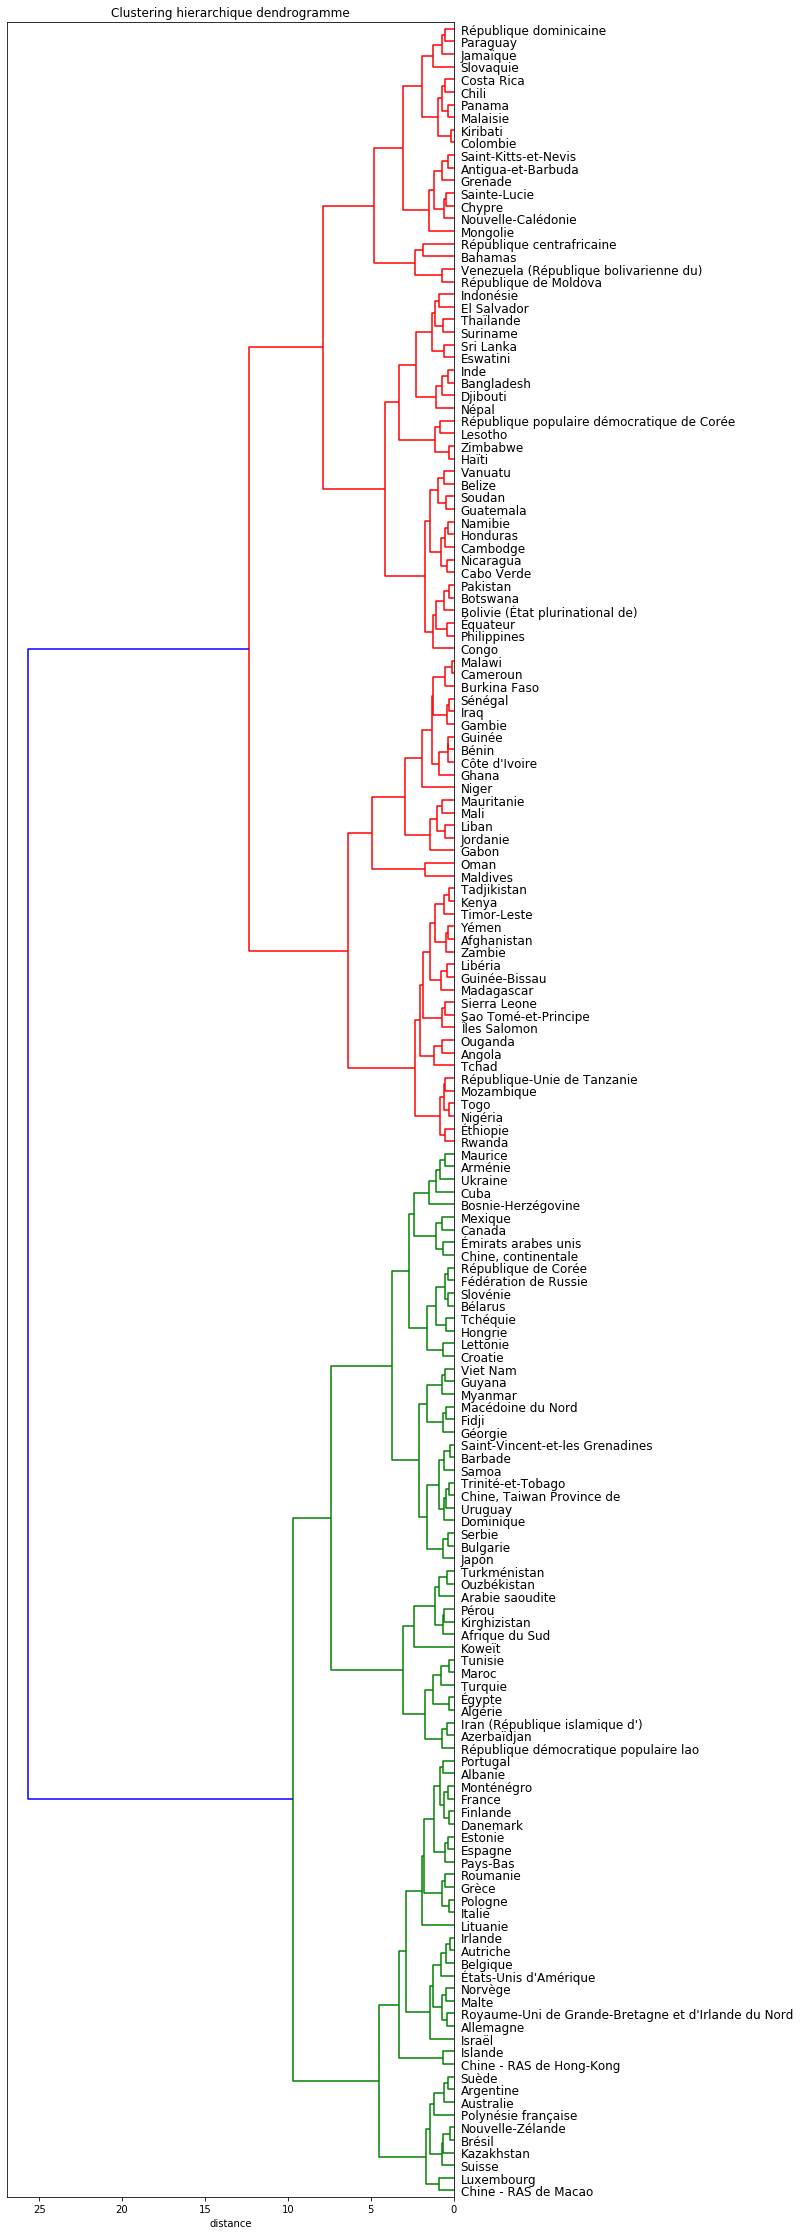

In [137]:
#affichage du dendogramme
plt.figure(figsize = (8,40))
plt.title("Clustering hierarchique dendrogramme")
plt.xlabel('distance')
dendrogram(
    Z,
    labels = names ,
    orientation = "left",
)
ax = plt.gca() 
ax.tick_params(axis='x', which='major', labelsize=10) 
ax.tick_params(axis='y', which='major', labelsize=12) 
plt.show()

In [138]:
#coupage du dendrogramme en 5 clusters 
clusters = fcluster(Z, 5, criterion='maxclust')
collections.Counter(clusters)

Counter({3: 39, 2: 48, 1: 35, 5: 21, 4: 29})

In [139]:
#ajout des clusters sur le DF
dataAvecCluster = dataClustering.copy()
dataAvecCluster["cluster_dendro"] = clusters

In [140]:
#export du fichier en csv
dataAvecCluster.to_csv("P5_03_code_listePaysCluster_1erClustering.csv")

### Clustering par Kmeans

In [141]:
n_clust = 5
km = KMeans (n_clusters = n_clust)
km.fit(X_scaled)
clustersKm = km.labels_

In [142]:
collections.Counter(clustersKm)

Counter({4: 39, 1: 20, 3: 45, 0: 38, 2: 30})

# Caractérisation des clusters 

#### descriptive

In [143]:
clusterCarac = dataAvecCluster.groupby("cluster_dendro").agg(["mean","std","var"])
clusterCarac

croissance_pop_14_17                     ratio_protani_prottot  \
                               mean       std       var                  mean   
cluster_dendro                                                                  
1                          0.016450  0.021756  0.000473              0.607094   
2                          0.020090  0.028288  0.000800              0.446411   
3                          0.089476  0.019138  0.000366              0.246908   
4                          0.043771  0.019182  0.000368              0.325219   
5                          0.027979  0.018790  0.000353              0.554047   

                                   dispo_prot_total_kgpersan            \
                     std       var                      mean       std   
cluster_dendro                                                           
1               0.050955  0.002596                 39.806587  4.021843   
2               0.098889  0.009779                 32.979499  2.698761   
3               0.103523  0.010717                 22.759154  4.138656   
4               0.092528  0.008561                 23.335079  2.159255   
5               0.073702  0.005432                 26.720433  3.874025   

                          dispo_alim_total_kcalpersan                 \
                      var                        mean            std   
cluster_dendro                                                         
1               16.175224                1.241751e+06   70993.145376   
2                7.283311                1.135241e+06   81218.699441   
3               17.128477                8.927058e+05  109883.617365   
4                4.662381                9.174212e+05   76807.546686   
5               15.008068                9.602281e+05  126657.203906   

                              
                         var  
cluster_dendro                
1               5.040027e+09  
2               6.596477e+09  
3               1.207441e+10  
4               5.899399e+09  
5               1.604205e+10

In [144]:
clusterCaracMean = dataAvecCluster.groupby("cluster_dendro").mean()


### inférentielles

##### Adéquation

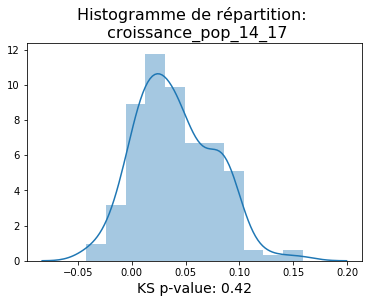

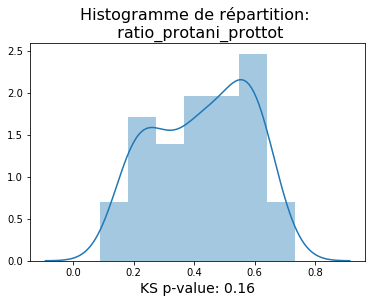

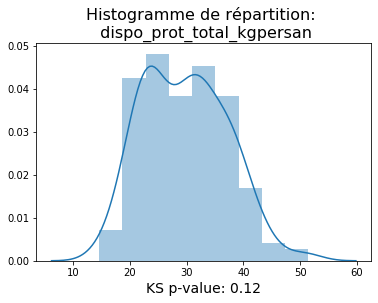

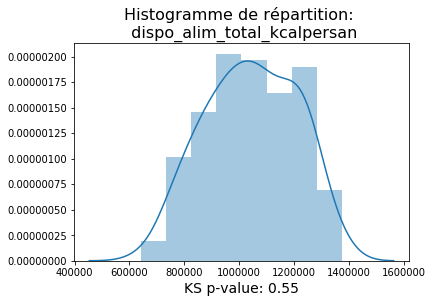

In [145]:
#adéquation à une loi normale
for column in dataClustering:
    sns.distplot(dataClustering[column])
    plt.title("Histogramme de répartition: \n {}".format(column), size= 16)
    plt.xlabel("KS p-value: {}".format(ks_2samp(dataClustering[column],
                                                list(numpy.random.normal(numpy.mean(dataClustering[column]),numpy.std(dataClustering[column]),10000))).pvalue.round(2)),size = 14)
    plt.show()


#### comparaison 2 variables gaussiennes

In [146]:
dataAvecCluster[dataAvecCluster["cluster_dendro"]== 1].croissance_pop_14_17

pays
Albanie                                               -0.004188
Allemagne                                              0.014831
Argentine                                              0.030481
Australie                                              0.041879
Autriche                                               0.023759
Belgique                                               0.017691
Brésil                                                 0.025005
Chine - RAS de Hong-Kong                               0.024059
Chine - RAS de Macao                                   0.054862
Danemark                                               0.012018
Espagne                                               -0.002790
Estonie                                                0.002363
Finlande                                               0.009148
France                                                 0.010109
Grèce                                                 -0.012336
Irlande                            

In [147]:
#fonction test fisher 
def PvalueFtest(var):
    name = var.columns 
    df = var.copy()
    df.columns=["variable","clusters"]
    
    tableauPvalue = pd.DataFrame(columns= sorted(df["clusters"].unique()), 
                                 index = sorted(df["clusters"].unique()))

    for i in sorted(df["clusters"].unique()):
        for z in sorted(df["clusters"].unique()):
            x = np.array(df[df["clusters"]== i]["variable"])
            y = np.array(df[df["clusters"]== z]["variable"])
            
            if np.var(x, ddof=1)>np.var(y, ddof=1):
                f = np.var(x, ddof=1)/np.var(y, ddof=1)
                dfn = x.size-1
                dfd = y.size-1
                a = 1-scipy.stats.f.cdf(f,dfn,dfd)
            else:
                f = np.var(y, ddof=1)/np.var(x, ddof=1)
                dfn = y.size-1
                dfd = x.size-1
                a = 1-scipy.stats.f.cdf(f,dfn,dfd)
            tableauPvalue.loc[i,z]=a
    tableauPvalueBon = tableauPvalue.astype("float64")
    ax = plt.axes()
    mask = np.zeros_like(tableauPvalue)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        sns.heatmap(tableauPvalueBon, mask=mask, square=True,linewidths= .5, annot=True, ax=ax)
    ax.set_title("F test egalité des variances pValue"+"\n"+ name[0], size = 16)
    plt.show()  

In [148]:
#fonction test bartlett 
def PvalueBtest(var):
    name = var.columns 
    df = var.copy()
    df.columns=["variable","clusters"]
    
    tableauPvalue = pd.DataFrame(columns= sorted(df["clusters"].unique()), 
                                 index = sorted(df["clusters"].unique()))

    for i in sorted(df["clusters"].unique()):
        for z in sorted(df["clusters"].unique()):
            a = scipy.stats.bartlett(df[df['clusters']==i]["variable"],
                                   df[df["clusters"]==z]["variable"]).pvalue
            tableauPvalue.loc[i,z]=a
    tableauPvalueBon = tableauPvalue.astype("float64")
    ax = plt.axes()
    mask = np.zeros_like(tableauPvalue)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        sns.heatmap(tableauPvalueBon, mask=mask, square=True,linewidths= .5, annot=True, ax=ax)
    ax.set_title("F test egalité des variances pValue"+"\n"+ name[0], size = 16)
    plt.show() 

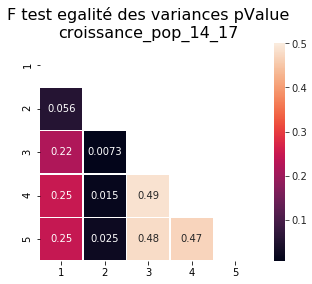

None


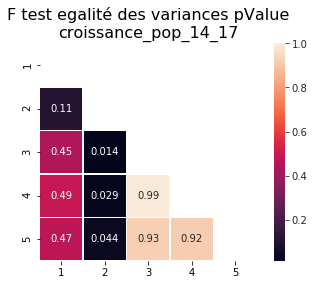

None


In [149]:
print(PvalueFtest(dataAvecCluster [["croissance_pop_14_17","cluster_dendro"]]))
print(PvalueBtest(dataAvecCluster [["croissance_pop_14_17","cluster_dendro"]]))

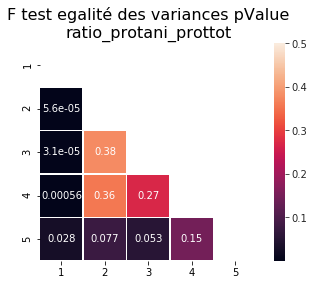

None


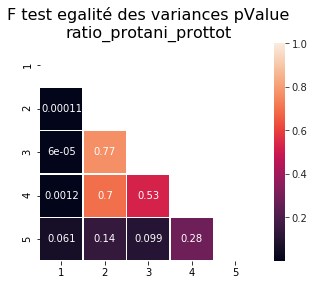

None


In [150]:
print(PvalueFtest(dataAvecCluster [["ratio_protani_prottot","cluster_dendro"]]))
print(PvalueBtest(dataAvecCluster [["ratio_protani_prottot","cluster_dendro"]]))

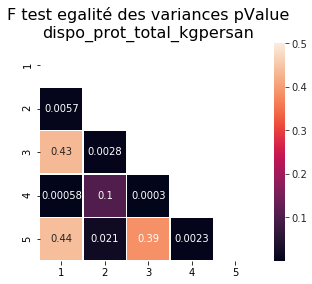

None


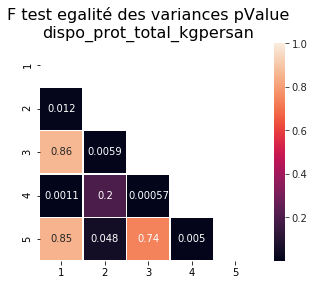

None


In [151]:
print(PvalueFtest(dataAvecCluster [["dispo_prot_total_kgpersan","cluster_dendro"]]))
print(PvalueBtest(dataAvecCluster [["dispo_prot_total_kgpersan","cluster_dendro"]]))

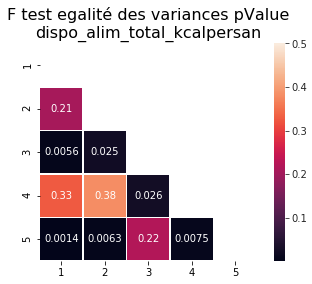

None


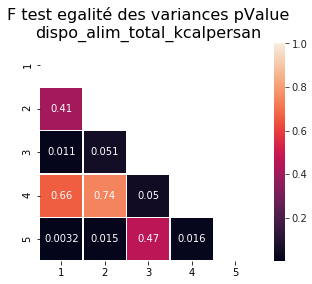

None


In [152]:
print(PvalueFtest(dataAvecCluster [["dispo_alim_total_kcalpersan","cluster_dendro"]]))
print(PvalueBtest(dataAvecCluster [["dispo_alim_total_kcalpersan","cluster_dendro"]]))

In [153]:
#fonction ttest
def PvalueTtest(var):
    name = var.columns 
    df = var.copy()
    df.columns=["variable","clusters"]
    
    tableauPvalue = pd.DataFrame(columns= sorted(df["clusters"].unique()), 
                                 index = sorted(df["clusters"].unique()))

    for i in sorted(df["clusters"].unique()):
        for z in sorted(df["clusters"].unique()):
            a = scipy.stats.ttest_ind(df[df['clusters']==i]["variable"],
                                   df[df["clusters"]==z]["variable"], equal_var=True).pvalue
            tableauPvalue.loc[i,z]=a
    tableauPvalueBon = tableauPvalue.astype("float64")
    ax = plt.axes()
    sns.heatmap(tableauPvalueBon,annot=True)
    ax.set_title("Ttest pValue"+ "\n" + name[0], size = 16)
    plt.xlabel("Moyenne cluster",size = 12)
    plt.ylabel("Cluster testé", size = 12)
    plt.show()  

In [154]:
#fonction welch ttest
def PvalueWTtest(var):
    name = var.columns 
    df = var.copy()
    df.columns=["variable","clusters"]
    
    tableauPvalue = pd.DataFrame(columns= sorted(df["clusters"].unique()), 
                                 index = sorted(df["clusters"].unique()))

    for i in sorted(df["clusters"].unique()):
        for z in sorted(df["clusters"].unique()):
            a = scipy.stats.ttest_ind(df[df['clusters']==i]["variable"],
                                   df[df["clusters"]==z]["variable"], equal_var=False).pvalue
            tableauPvalue.loc[i,z]=a
    tableauPvalueBon = tableauPvalue.astype("float64")
    ax = plt.axes()
    mask = np.zeros_like(tableauPvalue)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        sns.heatmap(tableauPvalueBon, mask=mask, square=True,linewidths= .5, annot=True, ax=ax)
    ax.set_title("WTtest pValue"+"\n"+ name[0], size = 16)
    plt.show() 

In [155]:
def Diff_significative_avec_verif_variance(var):
    name = var.columns 
    df = var.copy()
    df.columns=["variable","clusters"]
    
    tableauPvalue = pd.DataFrame(columns= sorted(df["clusters"].unique()), 
                                 index = sorted(df["clusters"].unique()))
    for i in sorted(df["clusters"].unique()):
        for z in sorted(df["clusters"].unique()):
            x = np.array(df[df["clusters"]== i]["variable"])
            y = np.array(df[df["clusters"]== z]["variable"])
            if np.var(x, ddof=1)>np.var(y, ddof=1):
                f = np.var(x, ddof=1)/np.var(y, ddof=1)
                dfn = x.size-1
                dfd = y.size-1
                a = 1-scipy.stats.f.cdf(f,dfn,dfd)
            else:
                f = np.var(y, ddof=1)/np.var(x, ddof=1)
                dfn = y.size-1
                dfd = x.size-1
                a = 1-scipy.stats.f.cdf(f,dfn,dfd)
                
            if a<0.05:
                b = scipy.stats.ttest_ind(df[df['clusters']==i]["variable"],
                                   df[df["clusters"]==z]["variable"], equal_var=False).pvalue
                tableauPvalue.loc[i,z]=b
            else :
                c =scipy.stats.ttest_ind(df[df['clusters']==i]["variable"],
                                   df[df["clusters"]==z]["variable"], equal_var=True).pvalue
                tableauPvalue.loc[i,z]=c
    tableauPvalueBon = tableauPvalue.astype("float64")
    ax = plt.axes()
    sns.heatmap(tableauPvalueBon,annot=True)
    ax.set_title("Différence significative pValue"+ "\n" + name[0], size = 16)
    plt.ylabel("Cluster testé", size = 12)
    plt.show()  


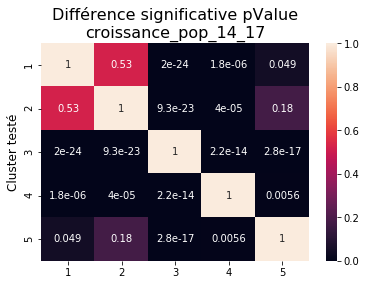

In [156]:
Diff_significative_avec_verif_variance(dataAvecCluster [["croissance_pop_14_17","cluster_dendro"]])

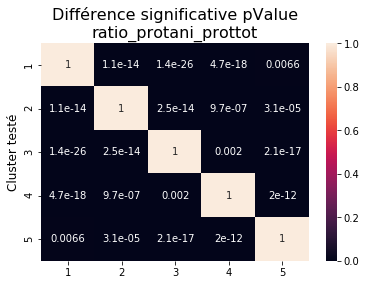

In [157]:
Diff_significative_avec_verif_variance(dataAvecCluster [["ratio_protani_prottot","cluster_dendro"]])

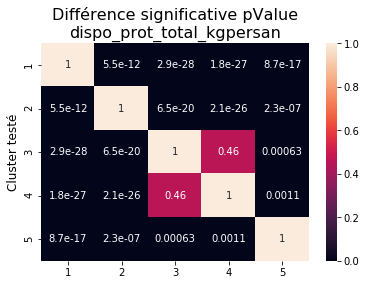

In [158]:
Diff_significative_avec_verif_variance(dataAvecCluster [["dispo_prot_total_kgpersan","cluster_dendro"]])

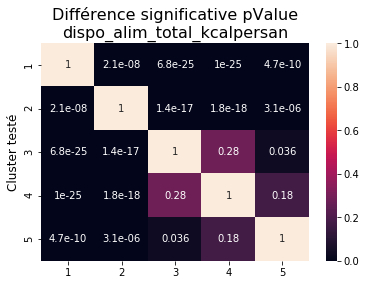

In [159]:
Diff_significative_avec_verif_variance(dataAvecCluster [["dispo_alim_total_kcalpersan","cluster_dendro"]])

# ACP 

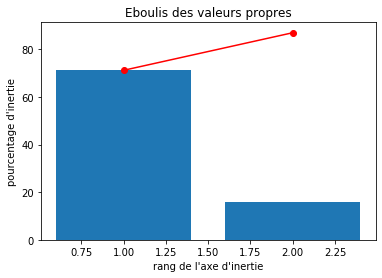

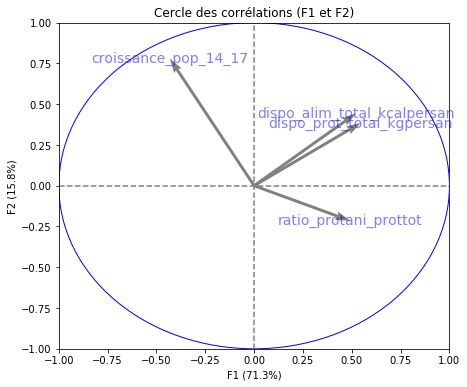

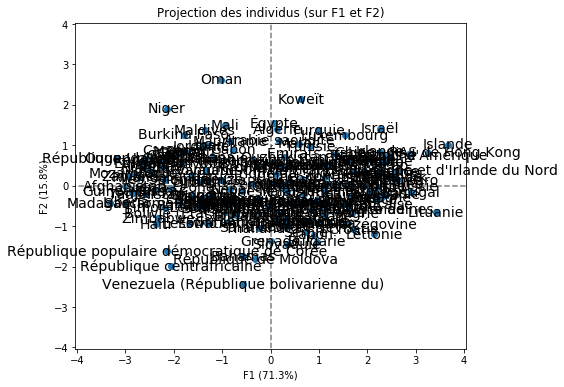

In [160]:
dataClustering = dataClustering[["croissance_pop_14_17","ratio_protani_prottot","dispo_prot_total_kgpersan","dispo_alim_total_kcalpersan"]]
dataClustering

# nombres de composantes 
n_comp = 2

#préparation données ACP
X = dataClustering.values
names = dataClustering.index
features = dataClustering.columns

#centrage et réduction 
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

#calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

#éboulis des valeurs propres 
display_scree_plot(pca)

#cercle des corrélations 
pcs = pca.components_
display_circles(pcs, n_comp, pca , [(0,1)], labels = np.array(features))

#projection des individus 
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected,n_comp,pca,[(0,1)],labels = np.array(names))

plt.show()


### Calcul des composantes principales 

In [161]:
#valeurs des composantes
pd.DataFrame (X_projected, index = dataClustering.index, columns=["F"+str(i+1)for i in range(2)])

,F1,F2
pays,,
Afghanistan,-3.016006,-0.017068
Afrique du Sud,0.113166,0.301182
Albanie,2.589176,0.129216
Algérie,0.137326,1.410093
Allemagne,2.280213,0.333084
Angola,-2.594551,0.513426
Antigua-et-Barbuda,0.350289,-0.933786
Arabie saoudite,0.176150,1.117049
Argentine,1.791781,0.287102


In [162]:
#calcul des composantes 
f1 = pca.components_[0].round(2)
f2 = pca.components_[1].round(2)
print(f1)
print(f2)

[-0.43  0.49  0.55  0.52]
[ 0.78 -0.21  0.39  0.44]


# ACP Détails

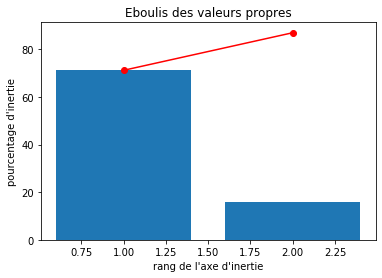

In [163]:
#éboulis des valeurs propres 
scree = pca.explained_variance_ratio_*100
plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

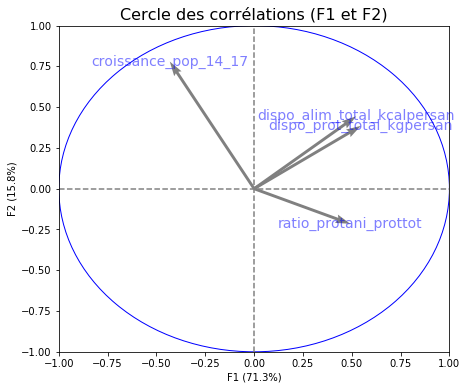

In [164]:
#cercle des corrélations
axis_ranks= [(0,1)]
pcs = pca.components_
for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
    if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                    plt.text(x, y, np.array(features)[i], fontsize='14', ha='center', va='center', rotation=0, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1),size = 16)
            plt.show(block=False)

In [165]:
dataClustering = dataClustering[["croissance_pop_14_17","ratio_protani_prottot","dispo_prot_total_kgpersan","dispo_alim_total_kcalpersan"]]
dataClustering

# nombres de composantes 
n_comp = 2

#préparation données ACP
X = dataClustering.values
names = dataClustering.index
features = dataClustering.columns

#centrage et réduction 
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

#calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

<Figure size 504x432 with 0 Axes>

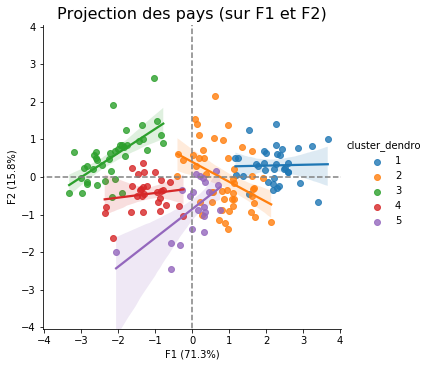

In [166]:
# projection des individus 
X_projected = pca.transform(X_scaled)
for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            dfScatter = pd.DataFrame(X_projected)
            dfScatter.columns= ["Xpos","Ypos"]
            dfScatter["cluster_dendro"] = clusters
            sns.lmplot(x="Xpos", y="Ypos",data=dfScatter,hue="cluster_dendro")
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des pays (sur F{} et F{})".format(d1+1, d2+1),size = 16)
            plt.show(block=False)

In [167]:
def couleur_cluster(cluster):
    if cluster == 1:
        val = '#4B92C3'
    elif cluster == 2:
        val = '#FF983D'
    elif cluster == 3:
        val = '#56B356'
    elif cluster == 4:
        val = '#DE5354'
    elif cluster == 5:
        val = '#A985CA'
    return val

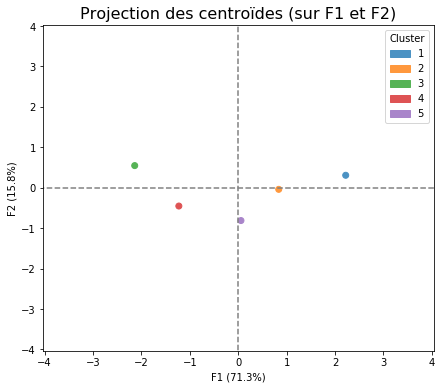

In [168]:
#pojection des centoïdes clusterCaracMean
caclulMeanX_projected = pd.DataFrame(X_projected)
caclulMeanX_projected["cluster"]= clusters
caclulMeanX_projected = caclulMeanX_projected.groupby("cluster").agg("mean")
caclulMeanX_projectedValue = caclulMeanX_projected.values
caclulMeanX_projected = caclulMeanX_projected.reset_index()
caclulMeanX_projected.columns = ["cluster",'Xpos','Ypos']
caclulMeanX_projected["color"]= caclulMeanX_projected["cluster"].apply(couleur_cluster)

# projection des centoïdes 
for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.subplots(figsize=(7,6))
        
            # affichage des points
            dfScatter = pd.DataFrame(caclulMeanX_projectedValue)
            dfScatter.columns= ["Xpos","Ypos"]
            plt.scatter(x="Xpos", y="Ypos",data=caclulMeanX_projected ,
                                 c ="color")
            clu_1 = matplotlib.patches.Patch(color='#4B92C3', label='1')
            clu_2 = matplotlib.patches.Patch(color='#FF983D', label='2')
            clu_3 = matplotlib.patches.Patch(color='#56B356', label='3')
            clu_4 = matplotlib.patches.Patch(color='#DE5354', label='4')
            clu_5 = matplotlib.patches.Patch(color='#A985CA', label='5')

            plt.legend( handles=[clu_1,clu_2,clu_3,clu_4,clu_5],title = "Cluster")

            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des centroïdes (sur F{} et F{})".format(d1+1, d2+1),size = 16)
            
    
            plt.show(block=False)

In [169]:
#export des centroïdes en csv
caclulMeanX_projected[["cluster","Xpos","Ypos"]].to_csv("P5_04_code_centroides_1erClustering.csv")

# Clustering et ACP avec plus de données 

In [170]:
#importation des données banque mondiale (pib/hab)
pibHab = pd.read_csv("pib_hab5.csv", decimal = "." ,sep="," ,encoding = "latin9", quotechar = '"')
pibHab = pibHab[["Country Name","Country Code","2017"]]
pibHab.columns = ["pays","code_pays","pib_hab_2017"]
pibHab.shape

(264, 3)

In [171]:
dataClusteringPlus = data[data["annee"]==2017]
dataClusteringPlus = dataClusteringPlus[["pays","code_pays","croissance_pop_14_17",
                                         "ratio_protani_prottot","dispo_prot_total_kgpersan",
                                         "dispo_alim_total_kcalpersan","export_volaille_kg",
                                         "import_volaille_kg","nourriture_volaille_kg",
                                         "production_volaille_kg"]]
dataClusteringPlus= dataClusteringPlus[dataClusteringPlus["code_pays"]!= "USA"]
dataClusteringPlus= dataClusteringPlus[dataClusteringPlus["code_pays"]!= "BRA"]
dataClusteringPlus.shape

(170, 10)

In [172]:
dataClusteringPlus = dataClusteringPlus.merge (pibHab, on ="code_pays")
dataClusteringPlus = dataClusteringPlus[["pays_x","croissance_pop_14_17","ratio_protani_prottot",
                                         "dispo_prot_total_kgpersan","dispo_alim_total_kcalpersan",
                                         "export_volaille_kg","import_volaille_kg","nourriture_volaille_kg",
                                         "production_volaille_kg","pib_hab_2017"]]
dataClusteringPlus = dataClusteringPlus.set_index("pays_x")
dataClusteringPlus

,croissance_pop_14_17,ratio_protani_prottot,dispo_prot_total_kgpersan,dispo_alim_total_kcalpersan,export_volaille_kg,import_volaille_kg,nourriture_volaille_kg,production_volaille_kg,pib_hab_2017
pays_x,,,,,,,,,
Afghanistan,0.087661,0.195045,19.74285,730000.0,0.000000e+00,2.900000e+07,5.500000e+07,2.800000e+07,556.302002
Afrique du Sud,0.045203,0.414339,30.44465,1092810.0,6.300000e+07,5.140000e+08,2.035000e+09,1.667000e+09,6132.479841
Albanie,-0.004188,0.554914,43.63575,1241000.0,0.000000e+00,3.800000e+07,4.700000e+07,1.300000e+07,4531.020806
Algérie,0.063342,0.276719,33.91215,1222385.0,0.000000e+00,2.000000e+06,2.640000e+08,2.750000e+08,4044.276600
Allemagne,0.014831,0.605374,38.03300,1297940.0,6.460000e+08,8.420000e+08,1.609000e+09,1.514000e+09,44349.589655
Angola,0.106711,0.304565,19.75015,828550.0,0.000000e+00,2.770000e+08,3.150000e+08,4.200000e+07,4095.812942
Antigua-et-Barbuda,0.031007,0.663720,29.72925,886950.0,0.000000e+00,7.000000e+06,5.000000e+06,0.000000e+00,15383.415188
Arabie saoudite,0.070660,0.422778,31.95210,1165810.0,1.000000e+07,7.220000e+08,1.435000e+09,6.160000e+08,20803.742566
Argentine,0.030481,0.639568,37.48915,1182235.0,2.070000e+08,8.000000e+06,1.856000e+09,2.161000e+09,14591.863381


In [173]:
dataClusteringPlus.isnull().sum()

croissance_pop_14_17           0
ratio_protani_prottot          0
dispo_prot_total_kgpersan      0
dispo_alim_total_kcalpersan    0
export_volaille_kg             0
import_volaille_kg             0
nourriture_volaille_kg         0
production_volaille_kg         0
pib_hab_2017                   3
dtype: int64

In [174]:
dataClusteringPlus[dataClusteringPlus["pib_hab_2017"].isna()]

,croissance_pop_14_17,ratio_protani_prottot,dispo_prot_total_kgpersan,dispo_alim_total_kcalpersan,export_volaille_kg,import_volaille_kg,nourriture_volaille_kg,production_volaille_kg,pib_hab_2017
pays_x,,,,,,,,,
Nouvelle-Calédonie,0.035146,0.583545,30.21105,1004480.0,0.0,9000000.0,11000000.0,1000000.0,NaN
Polynésie française,0.016194,0.659929,35.75175,1067260.0,0.0,15000000.0,13000000.0,1000000.0,NaN
Venezuela (République bolivarienne du),-0.021319,0.450782,20.54220,820155.0,0.0,25000000.0,596000000.0,600000000.0,NaN


In [175]:
dataClusteringPlus.loc["Venezuela (République bolivarienne du)",'pib_hab_2017']= 12500
dataClusteringPlus.loc["Nouvelle-Calédonie",'pib_hab_2017']= 33722
dataClusteringPlus.loc["Polynésie française",'pib_hab_2017']= 20720
dataClusteringPlus[dataClusteringPlus["pib_hab_2017"].isna()]

,croissance_pop_14_17,ratio_protani_prottot,dispo_prot_total_kgpersan,dispo_alim_total_kcalpersan,export_volaille_kg,import_volaille_kg,nourriture_volaille_kg,production_volaille_kg,pib_hab_2017
pays_x,,,,,,,,,


### ACP avec cluster 2,3,4,5

In [176]:
listePays456 = dataAvecCluster.reset_index()
listePays456 = listePays456["pays"][listePays456["cluster_dendro"].isin(["2","3","4","5"])]

In [177]:
dataClusteringPlusSans1 = dataClusteringPlus.reset_index()
dataClusteringPlusSans1 = dataClusteringPlusSans1[dataClusteringPlusSans1['pays_x'].isin(listePays456)]
dataClusteringPlusSans1 =dataClusteringPlusSans1[["pays_x","croissance_pop_14_17",
                                                        "ratio_protani_prottot",
                                                        "dispo_prot_total_kgpersan",
                                                        "dispo_alim_total_kcalpersan",
                                                        "export_volaille_kg","import_volaille_kg",
                                                        "nourriture_volaille_kg","production_volaille_kg",
                                                        "pib_hab_2017"]]                       
                         
dataClusteringPlusSans1 = dataClusteringPlusSans1.set_index('pays_x')

                    
                         

In [178]:
# nombres de composantes 
n_comp = 4

#préparation données ACP
X = dataClusteringPlusSans1.values
names = dataClusteringPlusSans1.index
features = dataClusteringPlusSans1.columns

#centrage et réduction 
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

#calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

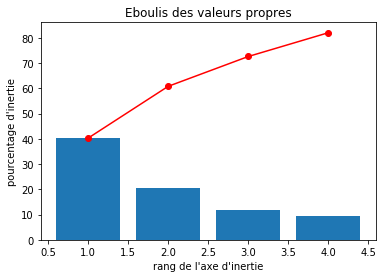

In [179]:
#éboulis des valeurs propres 
scree = pca.explained_variance_ratio_*100
plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

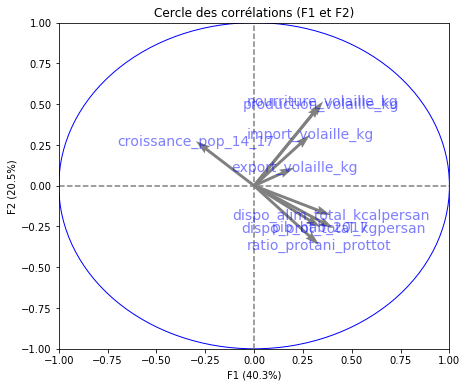

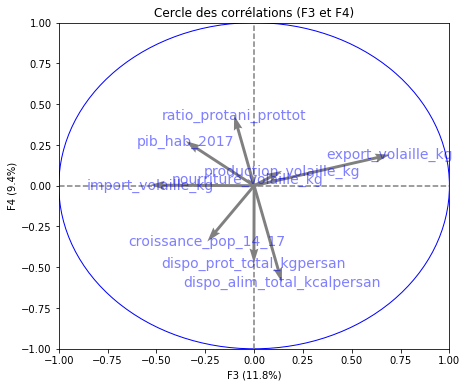

In [180]:
axis_ranks= [(0,1),(2,3)]
pcs = pca.components_
for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
    if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                    plt.text(x, y, np.array(features)[i], fontsize='14', ha='center', va='center', rotation=0, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

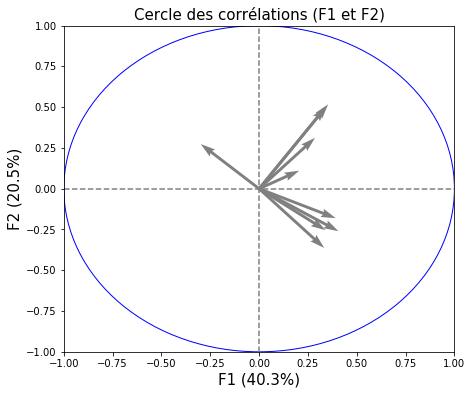

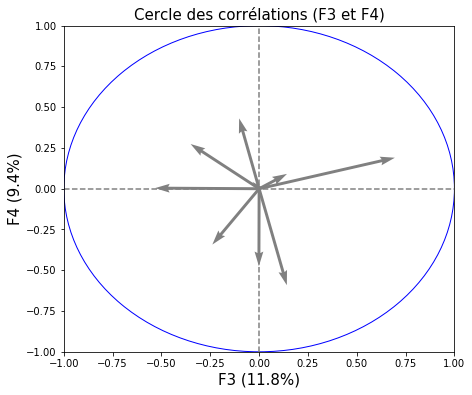

In [181]:
#cercle coré sans éciture 
axis_ranks= [(0,1),(2,3)]
pcs = pca.components_
for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
    if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)),fontsize = 15)
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)),fontsize = 15)

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1),fontsize = 15)
            plt.show(block=False)

In [182]:
#tableau des composantes 
f1 = pca.components_[0].round(2)
f2 = pca.components_[1].round(2)
f3 = pca.components_[2].round(2)
f4 = pca.components_[3].round(2)
ar = np.concatenate(([f1],[f2],[f3],[f4]))
composantes = pd.DataFrame(ar,
                          index = ["f1","f2","f3","f4"],
                          columns = dataClusteringPlusSans1.columns)
composantes

,croissance_pop_14_17,ratio_protani_prottot,dispo_prot_total_kgpersan,dispo_alim_total_kcalpersan,export_volaille_kg,import_volaille_kg,nourriture_volaille_kg,production_volaille_kg,pib_hab_2017
f1,-0.30,0.33,0.41,0.39,0.21,0.29,0.35,0.34,0.34
f2,0.27,-0.36,-0.26,-0.18,0.11,0.31,0.52,0.50,-0.25
f3,-0.24,-0.10,-0.00,0.14,0.70,-0.53,-0.03,0.14,-0.35
f4,-0.34,0.43,-0.48,-0.59,0.19,0.00,0.04,0.09,0.27


In [183]:
#detérmination du nombre de cluster pour Kmeans : Elbow, minimisation du la distance intraclasse
distortions = []
K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_scaled)
    distortions.append(kmeanModel.inertia_)

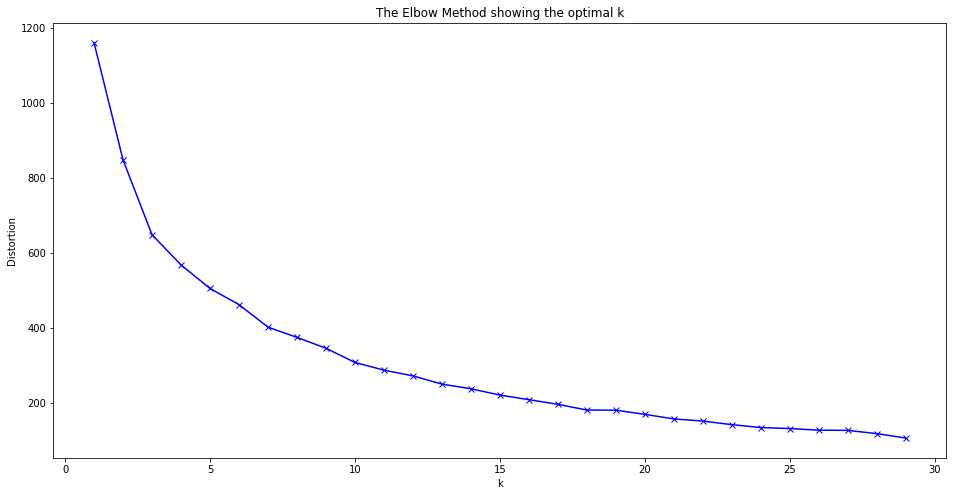

In [184]:
#graphique de distortion
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [185]:
#Clusterisation par Kmeans
n_clust = 10
km = KMeans (n_clusters = n_clust)
km.fit(X_scaled)
clustersKm = km.labels_
collections.Counter(clustersKm)

Counter({2: 35, 9: 10, 1: 17, 5: 24, 0: 4, 6: 23, 8: 1, 3: 10, 4: 2, 7: 3})

In [186]:
#Demarche sans export
dataClusteringPlusSans1AvecCluster = dataClusteringPlusSans1.copy()
dataClusteringPlusSans1AvecCluster["cluster"] = clustersKm
#EXPORT CSV puis suppression du code pour conserver les clusters quand on relance le code
dataClusteringPlusSans1AvecCluster = pd.read_csv("dataClusteringPlusSans1AvecCluster.csv")
dataClusteringPlusSans1AvecCluster = dataClusteringPlusSans1AvecCluster.set_index("pays_x")

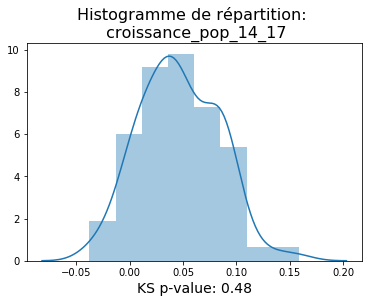

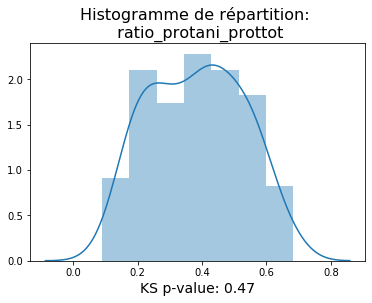

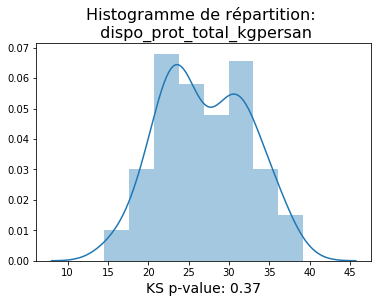

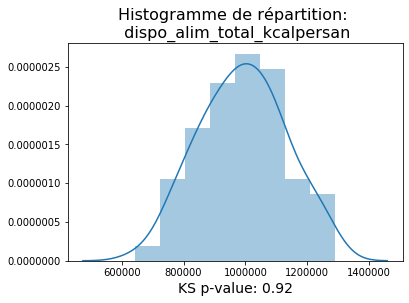

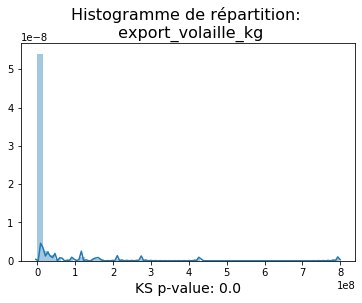

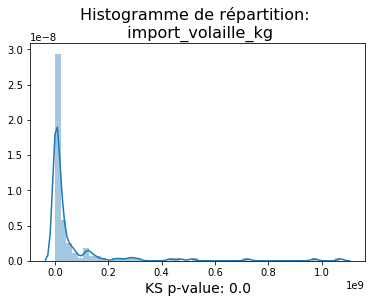

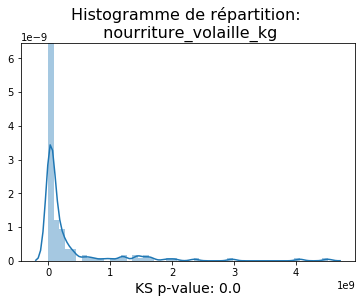

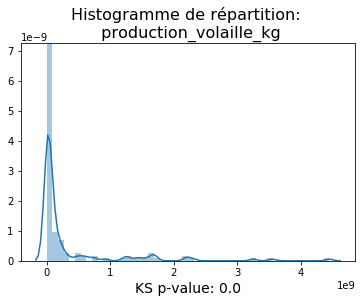

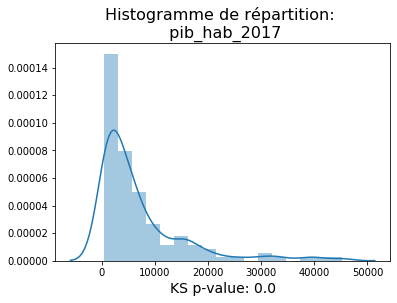

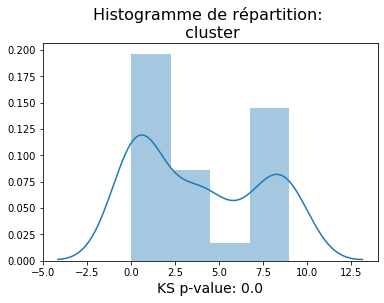

In [187]:
#normalité 
#adéquation à une loi normale
for column in dataClusteringPlusSans1AvecCluster:
    sns.distplot(dataClusteringPlusSans1AvecCluster[column])
    plt.title("Histogramme de répartition: \n {}".format(column), size= 16)
    plt.xlabel("KS p-value: {}".format(ks_2samp(dataClusteringPlusSans1AvecCluster[column],
                                                list(numpy.random.normal(numpy.mean(dataClusteringPlusSans1AvecCluster[column]),numpy.std(dataClusteringPlusSans1AvecCluster[column]),10000))).pvalue.round(2)),size = 14)
    plt.show()

In [188]:
#cluster carac
clusterCarac = dataClusteringPlusSans1AvecCluster.groupby("cluster").agg(["mean","std","var"])
clusterCarac

croissance_pop_14_17                     ratio_protani_prottot  \
                        mean       std       var                  mean   
cluster                                                                  
0                   0.012493  0.024663  0.000608              0.470111   
1                   0.077962  0.020315  0.000413              0.226537   
2                   0.034069  0.037999  0.001444              0.482277   
3                   0.015924  0.032333  0.001045              0.405448   
4                   0.090899  0.024176  0.000585              0.292622   
5                   0.019614  0.019281  0.000372              0.386488   
6                   0.052835  0.039923  0.001594              0.462367   
7                   0.041529  0.011804  0.000139              0.432608   
8                   0.024730  0.022019  0.000485              0.600153   
9                   0.037486  0.017435  0.000304              0.353135   

                            dispo_prot_total_kgpersan                       \
              std       var                      mean       std        var   
cluster                                                                      
0        0.100177  0.010036                 32.186995  2.562163   6.564678   
1        0.074314  0.005523                 19.824737  2.566610   6.587486   
2        0.067230  0.004520                 32.548267  1.347485   1.815715   
3        0.045174  0.002041                 30.224433  7.419458  55.048361   
4        0.123168  0.015170                 26.165025  3.415506  11.665679   
5        0.228145  0.052050                 30.512175  9.428173  88.890444   
6        0.048952  0.002396                 37.518350  1.463249   2.141099   
7        0.069407  0.004817                 28.147178  3.862683  14.920321   
8        0.069104  0.004775                 27.236964  3.725469  13.879122   
9        0.103779  0.010770                 24.294566  1.528088   2.335052   

        dispo_alim_total_kcalpersan                               \
                               mean            std           var   
cluster                                                            
0                      1.127414e+06   66350.295236  4.402362e+09   
1                      8.039204e+05   67079.058782  4.499600e+09   
2                      1.113372e+06  112336.026538  1.261938e+10   
3                      1.143910e+06  133832.614392  1.791117e+10   
4                      9.898136e+05   70357.963694  4.950243e+09   
5                      1.072918e+06  218089.408987  4.756299e+10   
6                      1.253653e+06   23272.387788  5.416040e+08   
7                      1.025934e+06   83005.361302  6.889890e+09   
8                      9.173777e+05   88811.224076  7.887434e+09   
9                      9.403230e+05   60034.184759  3.604103e+09   

        export_volaille_kg                             import_volaille_kg  \
                      mean           std           var               mean   
cluster                                                                     
0             2.087097e+07  4.877960e+07  2.379449e+15       3.635484e+07   
1             4.347826e+04  2.085144e+05  4.347826e+10       2.539130e+07   
2             9.666667e+06  5.773503e+05  3.333333e+11       9.210000e+08   
3             4.993333e+08  2.685002e+08  7.209233e+16       4.200000e+07   
4             1.363636e+06  3.970672e+06  1.576623e+13       5.245455e+07   
5             5.950000e+07  7.848885e+07  6.160500e+15       1.130000e+08   
6             8.700000e+07  7.973080e+07  6.357000e+15       2.506667e+08   
7             1.300000e+07  2.347871e+07  5.512500e+14       1.406667e+08   
8             3.272727e+06  1.052702e+07  1.108182e+14       1.754545e+07   
9             1.863636e+06  3.121286e+06  9.742424e+12       1.572727e+07   

                                    nourriture_volaille_kg                \
                  std           var                   mean         

In [189]:
#différence significative 

In [190]:
def Diff_significative_avec_verif__normalité_variance(var):
    name = var.columns #prep pour le graphique
    df = var.copy()#permet de travailler sur une copie
    df.columns=["variable","clusters"]#renomer pour travailler de façon générale
    tableauPvalue = pd.DataFrame(columns= sorted(df["clusters"].unique()), 
                                 index = sorted(df["clusters"].unique()))#initialisation du tableau pvalue
    #vérification de la normalité
    n = ks_2samp(df["variable"],
         list(numpy.random.normal(numpy.mean(df["variable"]),numpy.std(df["variable"]),10000))).pvalue
    if n<0.05:
        for i in sorted(df["clusters"].unique()):
            for z in sorted(df["clusters"].unique()):
                d=scipy.stats.mannwhitneyu(df[df['clusters']==i]["variable"],df[df["clusters"]==z]["variable"]).pvalue
                tableauPvalue.loc[i,z]=d
    else:
        for i in sorted(df["clusters"].unique()):
            for z in sorted(df["clusters"].unique()):
                x = np.array(df[df["clusters"]== i]["variable"])
                y = np.array(df[df["clusters"]== z]["variable"])
                if np.var(x, ddof=1)>np.var(y, ddof=1):
                    f = np.var(x, ddof=1)/np.var(y, ddof=1)
                    dfn = x.size-1
                    dfd = y.size-1
                    a = 1-scipy.stats.f.cdf(f,dfn,dfd)
                else:
                    f = np.var(y, ddof=1)/np.var(x, ddof=1)
                    dfn = y.size-1
                    dfd = x.size-1
                    a = 1-scipy.stats.f.cdf(f,dfn,dfd)

                if a<0.05:
                    b = scipy.stats.ttest_ind(df[df['clusters']==i]["variable"],
                                       df[df["clusters"]==z]["variable"], equal_var=False).pvalue
                    tableauPvalue.loc[i,z]=b
                else :
                    c = scipy.stats.ttest_ind(df[df['clusters']==i]["variable"],
                                       df[df["clusters"]==z]["variable"], equal_var=True).pvalue
                    tableauPvalue.loc[i,z]=c
    tableauPvalueBon = tableauPvalue.astype("float64")
    plt.figure (figsize =(15,10))
    ax = plt.axes()
    sns.heatmap(tableauPvalueBon,annot=True)
    ax.set_title("Différence significative pValue"+ "\n" + name[0], size = 16)
    plt.ylabel("Cluster testé", size = 12)
    plt.show() 

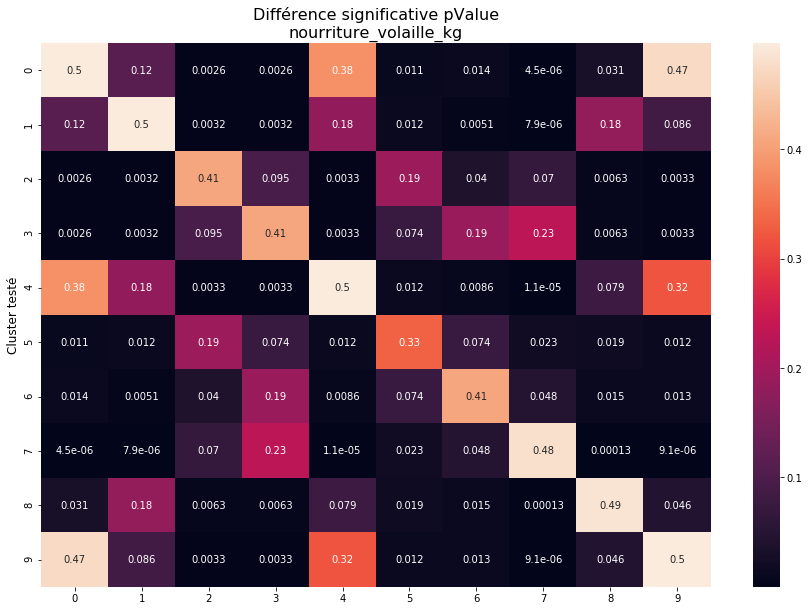

In [191]:
Diff_significative_avec_verif__normalité_variance(dataClusteringPlusSans1AvecCluster[['nourriture_volaille_kg',"cluster"]])

In [192]:
clusterCarac.import_volaille_kg.sort_values("mean")

,mean,std,var
cluster,,,
9,1.572727e+07,2.783828e+07,7.749697e+14
8,1.754545e+07,1.665751e+07,2.774727e+14
1,2.539130e+07,5.870476e+07,3.446249e+15
0,3.635484e+07,6.321158e+07,3.995703e+15
3,4.200000e+07,6.841783e+07,4.681000e+15
4,5.245455e+07,1.040292e+08,1.082207e+16
5,1.130000e+08,1.598061e+08,2.553800e+16
7,1.406667e+08,1.757541e+08,3.088950e+16
6,2.506667e+08,1.595003e+08,2.544033e+16


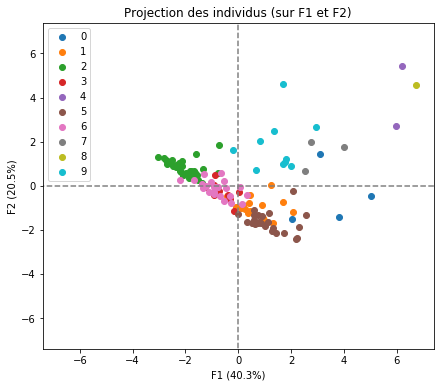

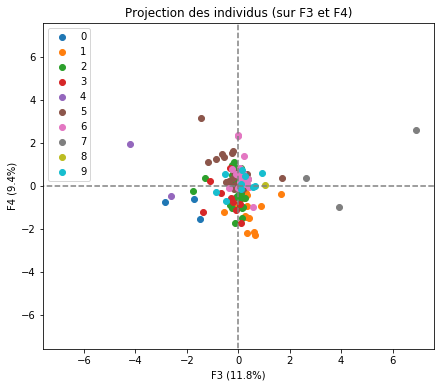

In [193]:
axis_ranks= [(0,1),(2,3)]
X_projected = pca.transform(X_scaled)
labels=dataClusteringPlusSans1AvecCluster.index
for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            illustrative_var = clustersKm
            for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=1, label=value)
            plt.legend()

                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

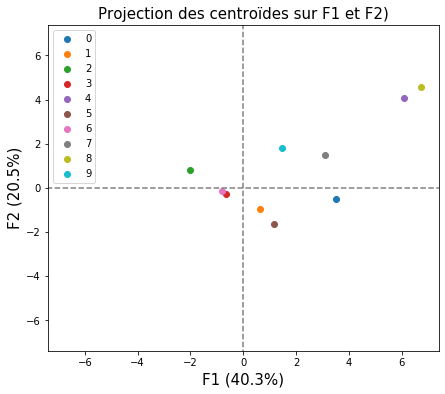

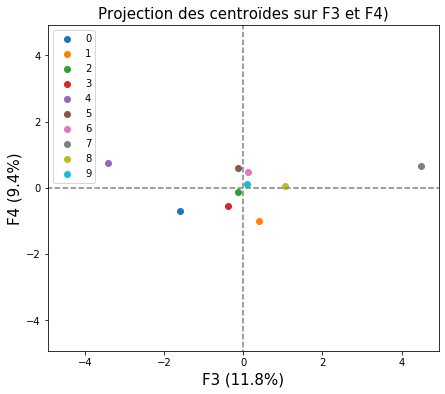

In [194]:
axis_ranks= [(0,1),(2,3)]
centroids = km.cluster_centers_
centroids_projected = pca.transform(centroids)
for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            illustrative_var = np.array([0, 1, 2, 3, 4, 5, 6,7,8,9])
            for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(centroids_projected[selected, d1], centroids_projected[selected, d2], alpha=1, label=value)
            plt.legend()

            # détermination des limites du graphique
            boundary = np.max(np.abs(centroids_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)),fontsize = 15)
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)),fontsize = 15)

            plt.title("Projection des centroïdes sur F{} et F{})".format(d1+1, d2+1),fontsize = 15)
            plt.show(block=False)

In [195]:
#Export centroïdes
dfCentroides = pd.DataFrame(centroids_projected,index =range (10),columns=["F1","F2","F3","F4"])
dfCentroides.to_csv("P5_04_code_centroides_2emeClustering.csv")

### Data vizualisation pays choisis

In [196]:
dataClusteringPlusSans1AvecCluster[dataClusteringPlusSans1AvecCluster["cluster"]==2] 

,croissance_pop_14_17,ratio_protani_prottot,dispo_prot_total_kgpersan,dispo_alim_total_kcalpersan,export_volaille_kg,import_volaille_kg,nourriture_volaille_kg,production_volaille_kg,pib_hab_2017,cluster
pays_x,,,,,,,,,,
Arabie saoudite,0.070660,0.422778,31.9521,1165810.0,10000000.0,7.220000e+08,1.435000e+09,6.160000e+08,20803.742566,2
Japon,-0.005196,0.555209,31.6017,984405.0,10000000.0,1.069000e+09,2.359000e+09,2.215000e+09,38386.511146,2
Mexique,0.036743,0.468844,34.0910,1189900.0,9000000.0,9.720000e+08,4.058000e+09,3.249000e+09,9278.418168,2


In [197]:
dataClusteringPlusSans1AvecCluster[dataClusteringPlusSans1AvecCluster["cluster"]==6] 

,croissance_pop_14_17,ratio_protani_prottot,dispo_prot_total_kgpersan,dispo_alim_total_kcalpersan,export_volaille_kg,import_volaille_kg,nourriture_volaille_kg,production_volaille_kg,pib_hab_2017,cluster
pays_x,,,,,,,,,,
Canada,0.029939,0.503656,36.93800,1274580.0,163000000.0,182000000.0,1.433000e+09,1.417000e+09,45148.552706,6
Koweït,0.098934,0.475155,36.43430,1257790.0,4000000.0,137000000.0,1.880000e+08,5.600000e+07,29759.436487,6
Émirats arabes unis,0.029632,0.408291,39.18275,1228590.0,94000000.0,433000000.0,4.120000e+08,4.800000e+07,40644.804043,6


In [198]:
dataClusteringPlusSans1AvecCluster[dataClusteringPlusSans1AvecCluster["cluster"]==0] 

,croissance_pop_14_17,ratio_protani_prottot,dispo_prot_total_kgpersan,dispo_alim_total_kcalpersan,export_volaille_kg,import_volaille_kg,nourriture_volaille_kg,production_volaille_kg,pib_hab_2017,cluster
pays_x,,,,,,,,,,
Algérie,0.063342,0.276719,33.91215,1222385.0,0.0,2000000.0,264000000.0,275000000.0,4044.276600,0
Arménie,0.011118,0.457739,35.54005,1123470.0,0.0,35000000.0,47000000.0,11000000.0,3914.501268,0
Azerbaïdjan,0.035737,0.326042,33.70775,1132595.0,0.0,27000000.0,129000000.0,104000000.0,4147.089716,0
Barbade,0.004915,0.564370,32.57625,1057040.0,0.0,2000000.0,13000000.0,15000000.0,17391.425866,0
Bosnie-Herzégovine,-0.037500,0.366698,34.56915,1193185.0,8000000.0,10000000.0,56000000.0,61000000.0,5394.591220,0
Bulgarie,-0.019765,0.499760,30.41910,1032220.0,45000000.0,108000000.0,157000000.0,107000000.0,8331.058025,0
Bélarus,0.001960,0.541870,34.34650,1200485.0,152000000.0,21000000.0,264000000.0,463000000.0,5761.747120,0
Chili,0.040063,0.513712,32.34265,1099015.0,115000000.0,155000000.0,672000000.0,712000000.0,14999.370089,0
Costa Rica,0.032229,0.561607,29.62340,1100475.0,3000000.0,17000000.0,131000000.0,133000000.0,11814.626569,0


In [199]:
print((dataClusteringPlusSans1AvecCluster[dataClusteringPlusSans1AvecCluster["cluster"]==6])
      .at["Émirats arabes unis","pib_hab_2017"])
print((dataClusteringPlusSans1AvecCluster[dataClusteringPlusSans1AvecCluster["cluster"]==6])
      .at["Émirats arabes unis","import_volaille_kg"])
print((dataClusteringPlusSans1AvecCluster[dataClusteringPlusSans1AvecCluster["cluster"]==6])
      .at["Émirats arabes unis","nourriture_volaille_kg"])
print((dataClusteringPlusSans1AvecCluster[dataClusteringPlusSans1AvecCluster["cluster"]==6])
      .at["Émirats arabes unis","production_volaille_kg"])
print((dataClusteringPlusSans1AvecCluster[dataClusteringPlusSans1AvecCluster["cluster"]==6])
      .at["Émirats arabes unis","export_volaille_kg"])
print((dataClusteringPlusSans1AvecCluster[dataClusteringPlusSans1AvecCluster["cluster"]==6])
      .at["Émirats arabes unis","croissance_pop_14_17"])
print((dataClusteringPlusSans1AvecCluster[dataClusteringPlusSans1AvecCluster["cluster"]==6])
      .at["Émirats arabes unis","dispo_prot_total_kgpersan"])

40644.804043392
433000000.0
412000000.0
48000000.0
94000000.0
0.02963153490764768
39.18275


In [200]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [201]:
listePays = np.array(["ARE","KWT","MEX","JPN","SAU"])

In [202]:
world["map"]= world.iso_a3.isin(listePays)

In [203]:
def pays(map):
    if map == True:
        val = '#4E7E2A'
    elif  map == False : 
        val = '#C1DCB8'
    return val

In [204]:
worldPaysSelec = world.copy()
worldPaysSelec["color"]= worldPaysSelec["map"].apply(pays)
worldPaysSelec = worldPaysSelec[worldPaysSelec["iso_a3"]!="ATA"]

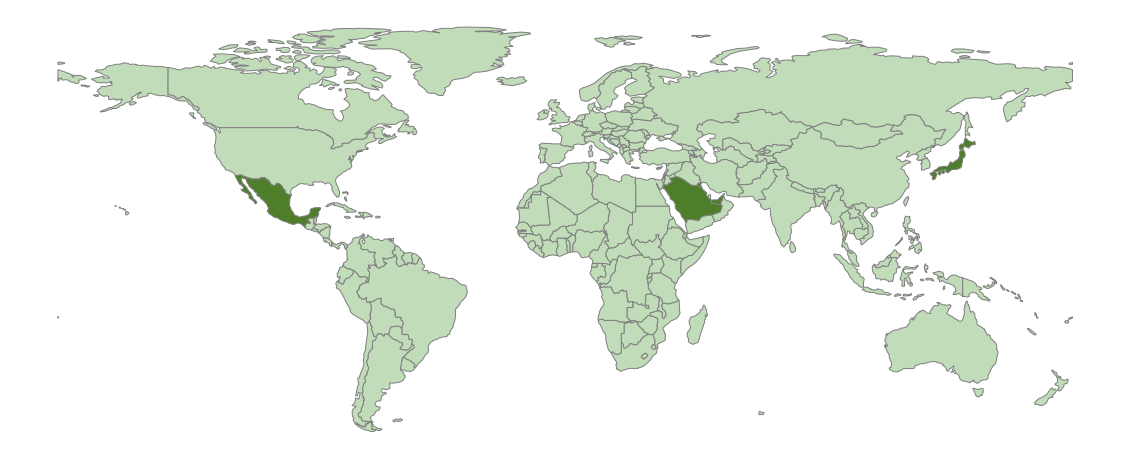

In [205]:

worldPaysSelec.plot(color = worldPaysSelec["color"],
                    legend =False,
                    figsize = (20,15),
                    edgecolor = 'gray'
                    )
plt.tick_params(bottom=False,      # ticks along the bottom edge are off
                labelleft = False,
                left = False,
                labelbottom=False)
plt.axis('off')
plt.show()